## Time Series Analysis of Daily Temperature for Berlin- Tempelhof

### Part 2: Short-term temperature forecast using AR model

####  Import libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# Set figure size to (16,8)
plt.rcParams['figure.figsize'] = (16,4)
# Set some easthetic
sns.set()
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import TimeSeriesSplit, cross_val_score


plt.rcParams['font.size'] = '14'

**The Dataset** 

The dataset is a cleaned subset spanning between 1950 - 09-2022 containing daily average temperature, timestep and seasonal dummies, from the previous part of the analyses 

In [101]:
df = pd.read_csv('../data/temp_subs_prepared_data.csv', parse_dates=True, index_col=0)

In [102]:
df.head()

,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1950-01-01,-3.5,0,0,0,0,0,0,0,0,0,0,0,0
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0
1950-01-03,2.9,2,0,0,0,0,0,0,0,0,0,0,0
1950-01-04,-0.1,3,0,0,0,0,0,0,0,0,0,0,0
1950-01-05,-3.0,4,0,0,0,0,0,0,0,0,0,0,0


### Train test split

**As train data, we will take everything but the last year, the last 365 days which will be reserved for testing**

In [103]:
df_train = df[:-365]
df_test = df[-365:] # take the last year to test

In [104]:
df_test.shape, df_train.shape

((365, 13), (26206, 13))

#### Define X , y

In [105]:
X_train = df_train.drop(['av_temp'], axis = 1)
y_train = df_train['av_temp']
X_test = df_test.drop(['av_temp'], axis = 1)
y_test = df_test['av_temp']

#### Model the trend with seasonality

In [106]:
##Instantiate and train the model**
m = LinearRegression()
m.fit(X_train,y_train)

LinearRegression()

**Use the model to predict the trend with seasonality**

In [107]:
df_train['trend_seasonal'] = m.predict(X_train)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\3742948870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend_seasonal'] = m.predict(X_train)


In [108]:
df_train.head(2)

,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
1950-01-01,-3.5,0,0,0,0,0,0,0,0,0,0,0,0,-0.495604
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0,-0.495533


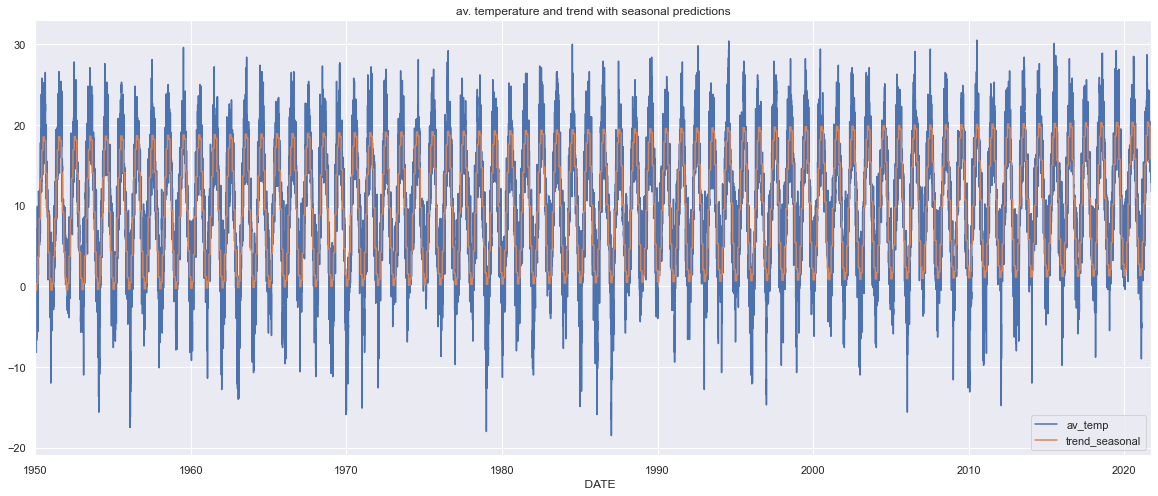

In [109]:
df_train[['av_temp','trend_seasonal']].plot(figsize=(20, 8)).set_title("av. temperature and trend with seasonal predictions");

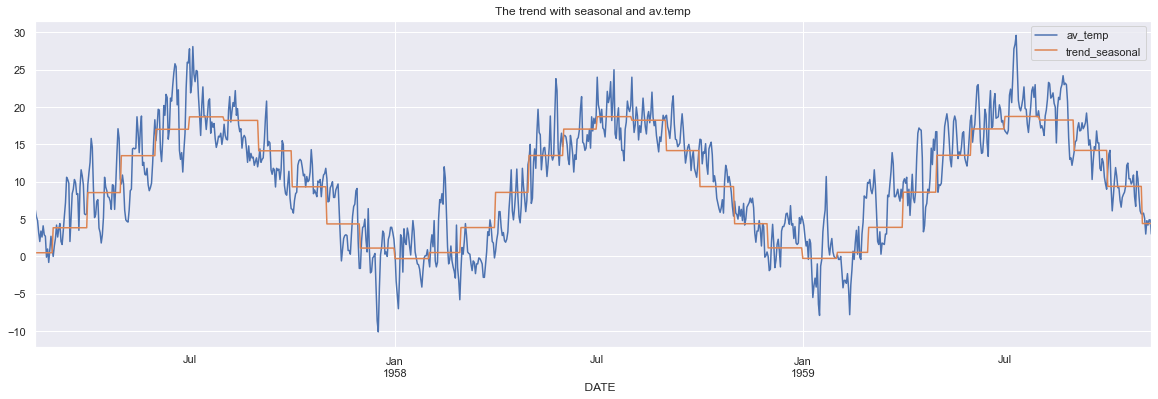

In [110]:
df_train[["av_temp", "trend_seasonal"]][2600:3600].plot(figsize = (20, 6)).set_title("The trend with seasonal and av.temp");

### Extract the remainder
part of the model that trend and seasonality is not able to explain, the noise. This is what we want to model with AR and ARIMA models for making short term predictions.


In [112]:
df_train['remainder'] = df_train['av_temp'] - df_train['trend_seasonal']

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\1602898085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['remainder'] = df_train['av_temp'] - df_train['trend_seasonal']


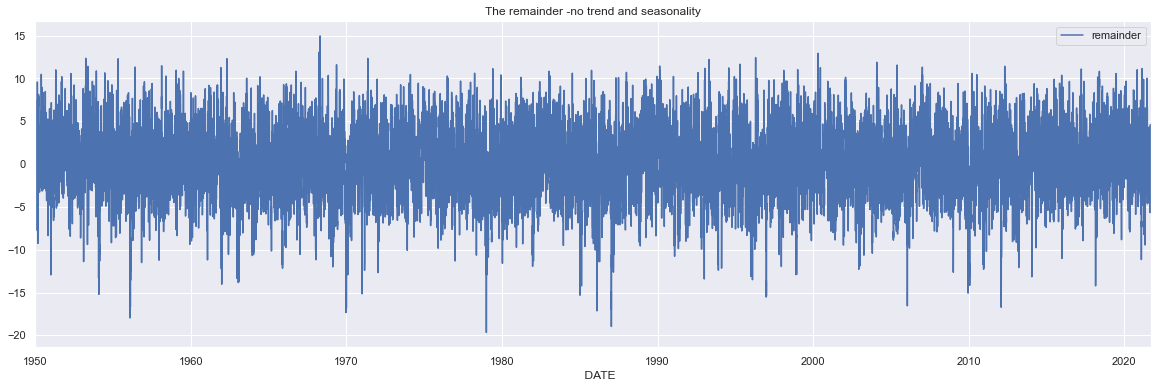

In [113]:
df_train[["remainder"]].plot(figsize = (20, 6)).set_title("The remainder -no trend and seasonality");

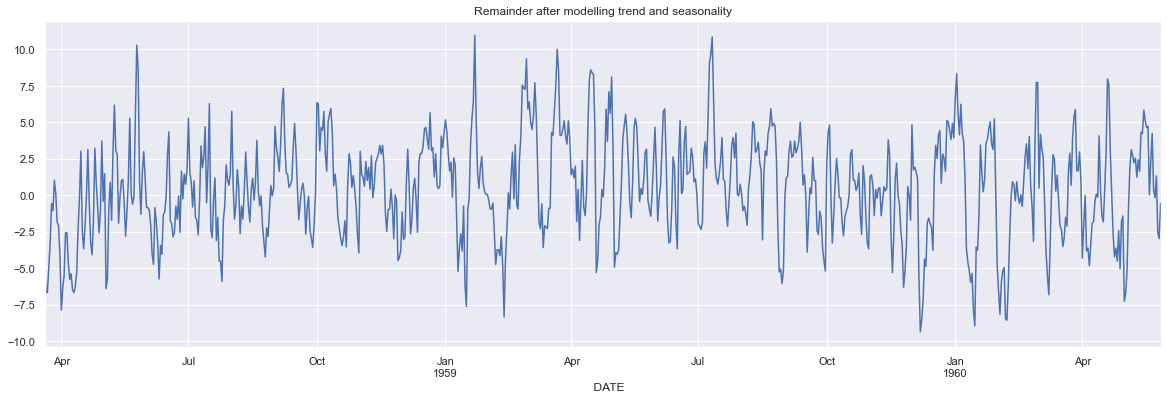

In [114]:
df_train['remainder'][3000:3800].plot(figsize = (20, 6)).set_title("Remainder after modelling trend and seasonality");

In [115]:
df_train["remainder"].std(), df_train["av_temp"].std()

(3.9257389704510417, 7.89951870327049)

In [116]:
#### Saving the remainder
train_remainder = df_train[['remainder']]
df_train['remainder'].to_csv('temp_train_remainder.csv')
df_train.to_csv('temp_train_remainder.csv')

### Model Selection
** Inspecting the remainder and decide on how many / which lags to include **

####  Autocorrelation and Partial Autocorrelation 
*** An exponential and slow decay in the ACF, and a drop in PACF-Plot shows after a certain lag, indicate that the data is best modelled by an AR(p) process as oppose to a sharp drop in the ACF plot at lag q which indicates an MA(q) process. 

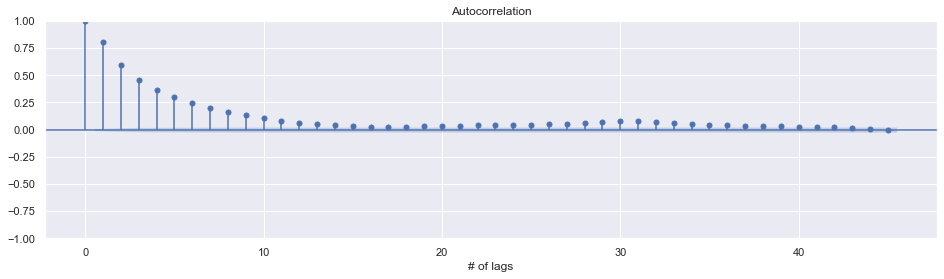

In [118]:
from statsmodels.graphics.tsaplots import plot_acf
plot = plot_acf(df_train['remainder'])
plt.xlabel('# of lags');

*** Looking at the pac plot below, it looks like 3 lags, the point after which we know the correlation dropped significantly.**

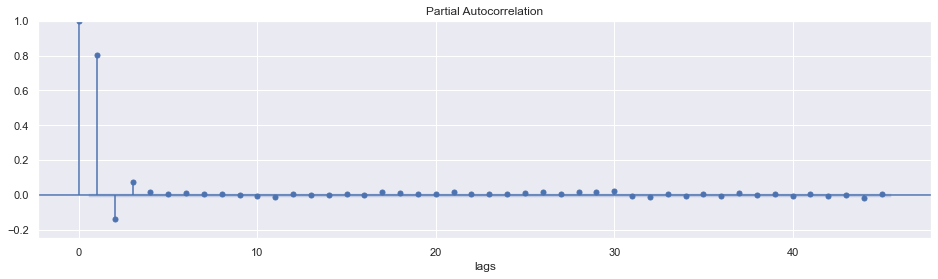

In [119]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train['remainder'], method='ywm')
plt.xlabel('lags')
plt.ylim(-0.25, 1);

### Statsmodels ar_select_order can also help in selecting lags

In [120]:
selected_order = ar_select_order(df_train['remainder'], maxlag = 15)

C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [121]:
print(f"The lag we need to include are {selected_order.ar_lags}")

The lag we need to include are [1, 2, 3]


### Add the lags of the remainder to the training data
##### Should we add a 3rd lags? I will first try the model with two

In [122]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\3243605767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['lag1'] = df_train['remainder'].shift(1)
C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\3243605767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['lag2'] = df_train['remainder'].shift(2)
C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\3243605767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [123]:
df_train.head(2)

,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
1950-01-01,-3.5,0,0,0,0,0,0,0,0,0,0,0,0,-0.495604,-3.004396,NaN,NaN,NaN
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0,-0.495533,1.495533,-3.004396,NaN,NaN


####  Drop the missing values created through lags

In [124]:
df_train.dropna(inplace=True)
df_train.head(2)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\2285376989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(inplace=True)


,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
1950-01-04,-0.1,3,0,0,0,0,0,0,0,0,0,0,0,-0.495392,0.395392,3.395463,1.495533,-3.004396
1950-01-05,-3.0,4,0,0,0,0,0,0,0,0,0,0,0,-0.495321,-2.504679,0.395392,3.395463,1.495533


####  Full AR Model (Linear Regression) with lag features and trend with seasonality

In [125]:
df_train.columns

Index(['av_temp', 'timestep', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'trend_seasonal', 'remainder', 'lag1', 'lag2', 'lag3'],
      dtype='object')

####  # Assign Xy and # fit the model

In [126]:
X_full = df_train.drop(['av_temp', 'trend_seasonal', 'remainder'], axis = 1)
y_full = df_train['av_temp']

In [127]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

####  Create a new predictions column

In [128]:
df_train['preds_full_model'] = m_full.predict(X_full)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\3449700597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['preds_full_model'] = m_full.predict(X_full)


In [129]:
m_full.coef_

array([ 7.07029639e-05,  8.26584890e-01,  4.16198417e+00,  8.84219473e+00,
        1.37424748e+01,  1.72758408e+01,  1.89727820e+01,  1.84277315e+01,
        1.44021392e+01,  9.58829198e+00,  4.63210068e+00,  1.41080200e+00,
        9.26810929e-01, -2.07228843e-01,  7.36142906e-02])

###  Using statsmodels AutoReg to do the modeling  

In [130]:
#Only use this if you feel comfortable
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog=train_remainder['remainder'], lags=3).fit()

C:\Users\ndafu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [131]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                26206
Model:                     AutoReg(3)   Log Likelihood              -59060.593
Method:               Conditional MLE   S.D. of innovations              2.305
Date:                Fri, 04 Nov 2022   AIC                         118131.186
Time:                        15:41:22   BIC                         118172.054
Sample:                    01-04-1950   HQIC                        118144.384
                         - 09-30-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.014     -0.015      0.988      -0.028       0.028
remainder.L1     0.9269      0.006    150.442      0.000       0.915       0.939
remainder.L2    -0.2073      0.008    -24.931      0.000      -0.224      -0.191
remainder.L3     0.0734      0.006     11.914      0.000       0.061       0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2790           -0.0000j            1.2790           -0.0000
AR.2            0.7723           -3.1711j            3.2638           -0.2120
AR.3            0.7723           +3.1711j            3.2638            0.2120
-----------------------------------------------------------------------------
"""

### Plot the prediction vs temperature for the training data

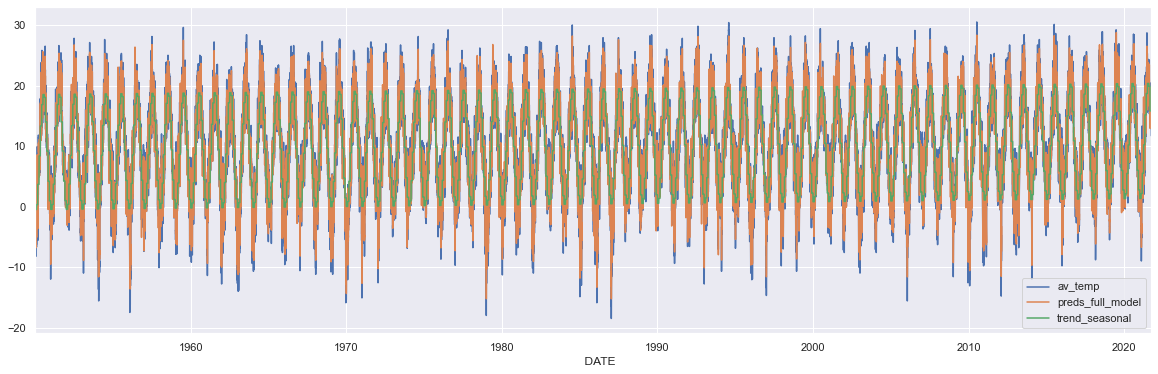

In [132]:
df_train[["av_temp", "preds_full_model", 'trend_seasonal']].plot(figsize = (20, 6));

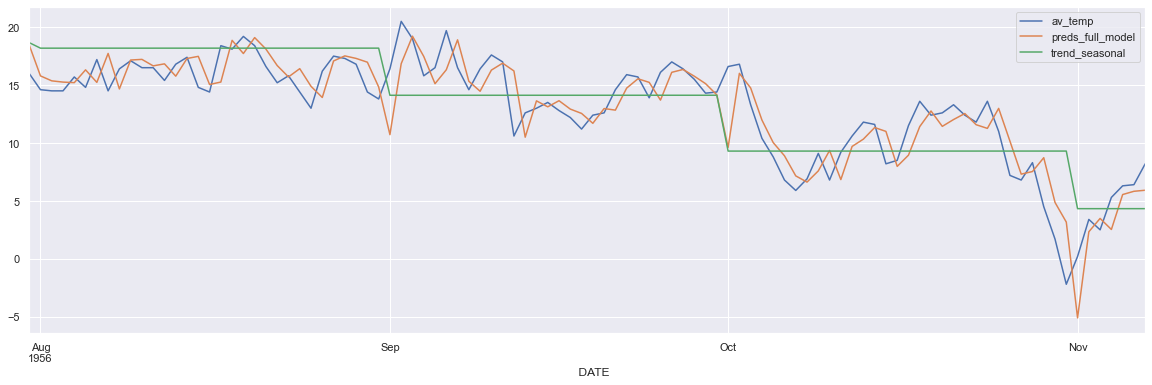

In [161]:
df_train[["av_temp", "preds_full_model", 'trend_seasonal']][2400:2500].plot(figsize = (20, 6));

### How good is the model?

###  Evaluate our model using cross-validation.

In [134]:
X_full.tail(2)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
2021-09-29,26204,0,0,0,0,0,0,0,1,0,0,0,-0.098649,2.201422,3.101493
2021-09-30,26205,0,0,0,0,0,0,0,1,0,0,0,-1.898719,-0.098649,2.201422


####  TimeSeriesSplit object and splitting the training data into validation folds

In [135]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=10)

In [136]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 2380 2381 2382]
The validation data for the 1th iteration are the observations steps
    [2383 2384 2385 ... 4762 4763 4764]


The training data for the 2th iteration are the observations steps 
    [   0    1    2 ... 4762 4763 4764]
The validation data for the 2th iteration are the observations steps
    [4765 4766 4767 ... 7144 7145 7146]


The training data for the 3th iteration are the observations steps 
    [   0    1    2 ... 7144 7145 7146]
The validation data for the 3th iteration are the observations steps
    [7147 7148 7149 ... 9526 9527 9528]


The training data for the 4th iteration are the observations steps 
    [   0    1    2 ... 9526 9527 9528]
The validation data for the 4th iteration are the observations steps
    [ 9529  9530  9531 ... 11908 11909 11910]


The training data for the 5th iteration are the observations steps 
    [    0     1     2 ... 11908 11909 11910]
The 

In [137]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

####  Cross validate: to get the testscores in the training data.

In [138]:
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.90677757, 0.91381085, 0.91128106, 0.91685483, 0.903951  ,
       0.89961931, 0.91039382, 0.92570729, 0.92371923, 0.91607194])

### Test your model     (on the test data)

In [139]:
df_test.head(2)

,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
2021-10-01,12.7,26206,0,0,0,0,0,0,0,0,1,0,0
2021-10-02,14.8,26207,0,0,0,0,0,0,0,0,1,0,0


#### Xy test

In [140]:
X_test = df_test.drop(['av_temp'], axis = 1)
y_test = df_test['av_temp']

#### predict the trend with seasonality column

In [141]:
df_test['trend_seasonal'] = m.predict(X_test)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\1458445851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['trend_seasonal'] = m.predict(X_test)


#### Calculate the remainder for the test set

In [142]:
df_test['remainder'] = df_test['av_temp'] - df_test['trend_seasonal']

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\2225323435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['remainder'] = df_test['av_temp'] - df_test['trend_seasonal']


#### Adding the 3 lags as as additional features for the AR model

In [143]:
# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\4193318670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag1'] = df_test['remainder'].shift(1)
C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\4193318670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag2'] = df_test['remainder'].shift(2)
C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\4193318670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [144]:
df_train.tail(3)

,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,preds_full_model
DATE,,,,,,,,,,,,,,,,,,,
2021-09-28,15.7,26203,0,0,0,0,0,0,0,1,0,0,0,15.798649,-0.098649,2.201422,3.101493,1.901564,17.319752
2021-09-29,13.9,26204,0,0,0,0,0,0,0,1,0,0,0,15.798719,-1.898719,-0.098649,2.201422,3.101493,15.462945
2021-09-30,11.7,26205,0,0,0,0,0,0,0,1,0,0,0,15.798790,-4.098790,-1.898719,-0.098649,2.201422,14.205073


#### Filling the missing values at the beginning of lag columns using remainder values in the train data

In [145]:
df_test.loc['2021-10-01', 'lag1'] = df_train.loc['2021-09-30', 'remainder']
df_test.loc['2021-10-01', 'lag2'] = df_train.loc['2021-09-29', 'remainder']
df_test.loc['2021-10-01', 'lag3'] = df_train.loc['2021-09-28', 'remainder']

df_test.loc['2021-10-02', 'lag2'] = df_train.loc['2021-09-30', 'remainder']
df_test.loc['2021-10-02', 'lag3'] = df_train.loc['2021-09-29', 'remainder']

df_test.loc['2021-10-03', 'lag3'] = df_train.loc['2021-09-30', 'remainder']

In [150]:
# Assign X_full
X_full = df_test.drop(columns=['av_temp', 'trend_seasonal', 'remainder'])

In [151]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
2021-10-01,26206,0,0,0,0,0,0,0,0,1,0,0,-4.098790,-1.898719,-0.098649
2021-10-02,26207,0,0,0,0,0,0,0,0,1,0,0,1.722613,-4.098790,-1.898719
2021-10-03,26208,0,0,0,0,0,0,0,0,1,0,0,3.822543,1.722613,-4.098790
2021-10-04,26209,0,0,0,0,0,0,0,0,1,0,0,7.122472,3.822543,1.722613
2021-10-05,26210,0,0,0,0,0,0,0,0,1,0,0,3.822401,7.122472,3.822543


In [152]:
df_test.shape

(365, 18)

In [153]:
# Create the predictions
df_test['preds_full_model'] = m_full.predict(X_full)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\738720944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds_full_model'] = m_full.predict(X_full)


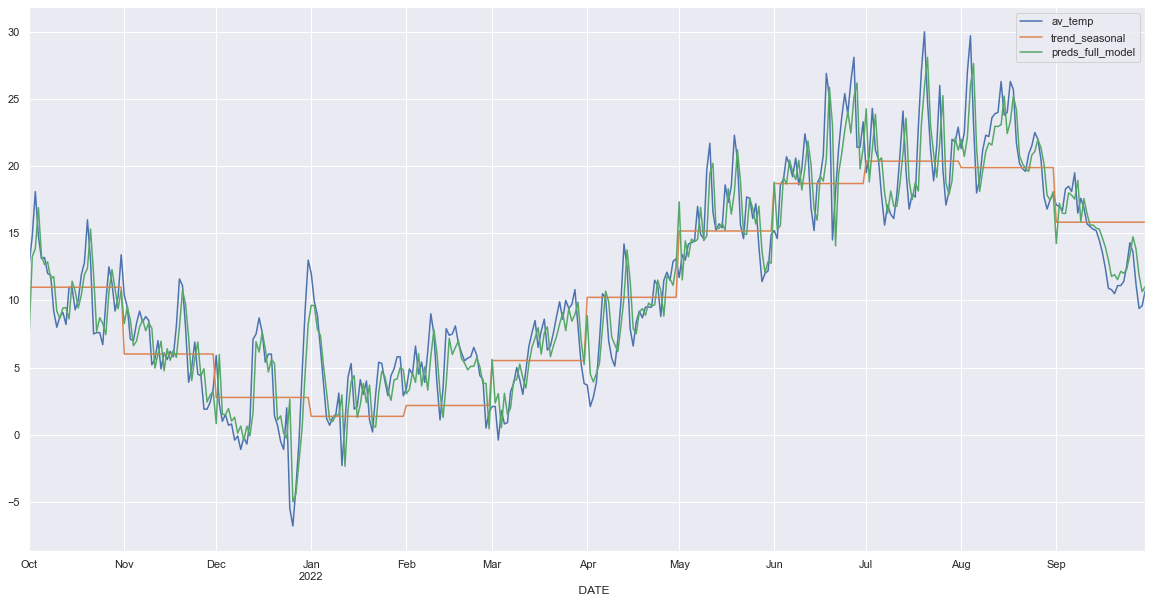

In [154]:
df_test[["av_temp", 'trend_seasonal', 'preds_full_model']].plot(figsize = (20, 10));

In [155]:
# Create the complete dataset and plot it
df_full_model = df_train[['av_temp', 'trend_seasonal', 'preds_full_model']].append(df_test[['av_temp', 'trend_seasonal', 'preds_full_model']])


C:\Users\ndafu\AppData\Local\Temp\ipykernel_32640\811937941.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full_model = df_train[['av_temp', 'trend_seasonal', 'preds_full_model']].append(df_test[['av_temp', 'trend_seasonal', 'preds_full_model']])


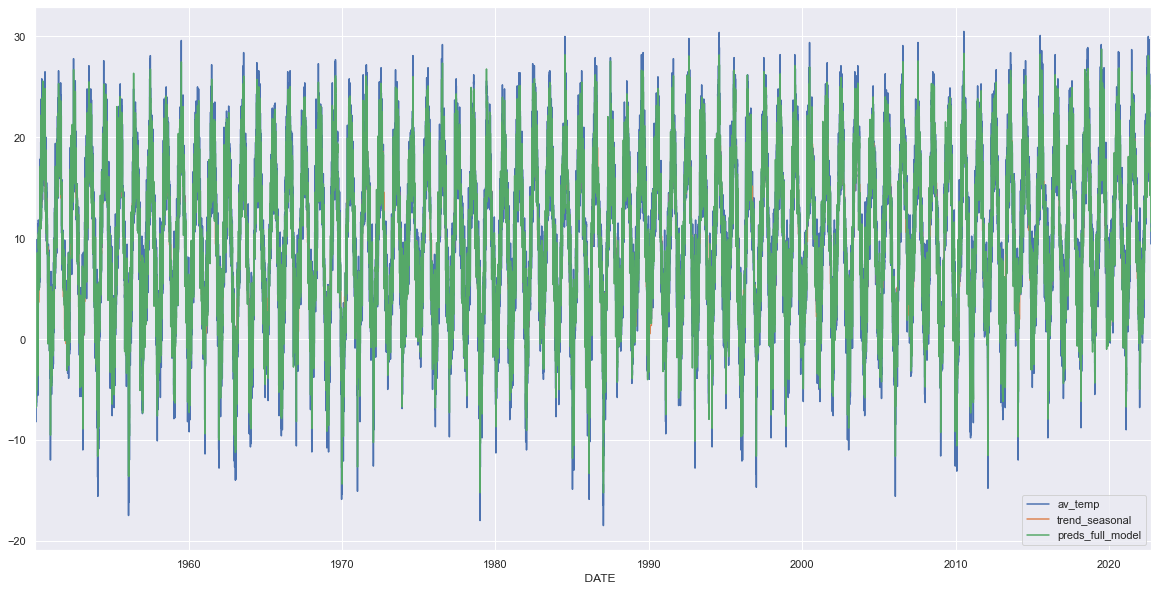

In [157]:
df_full_model.plot(figsize = (20, 10));

In [158]:
df_full_model.head()

,av_temp,trend_seasonal,preds_full_model
DATE,,,
1950-01-04,-0.1,-0.495392,2.143498
1950-01-05,-3.0,-0.495321,-0.699391
1950-01-06,2.3,-0.495251,-2.625574
1950-01-07,5.2,-0.495180,2.666659
1950-01-08,7.0,-0.495109,4.042631


In [159]:
print(f"""
full model = {m_full.score(X_full, df_test['av_temp'])}
trend_seasonal = {m.score(X_test, y_test)}
""")



full model = 0.9160476199304273
trend_seasonal = 0.7835746674374626



### Predict the future

So far we have just predicted data that we already had (train and test). We have not actually made any predictions for the future.

In [160]:
df_train.head(3)

,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,preds_full_model
DATE,,,,,,,,,,,,,,,,,,,
1950-01-04,-0.1,3,0,0,0,0,0,0,0,0,0,0,0,-0.495392,0.395392,3.395463,1.495533,-3.004396,2.143498
1950-01-05,-3.0,4,0,0,0,0,0,0,0,0,0,0,0,-0.495321,-2.504679,0.395392,3.395463,1.495533,-0.699391
1950-01-06,2.3,5,0,0,0,0,0,0,0,0,0,0,0,-0.495251,2.795251,-2.504679,0.395392,3.395463,-2.625574


### Combine train and test data and Re-train the model on full dataset

In [295]:
# Combine train and test data
df_combined = df_train.append(df_test)

C:\Users\ndafu\AppData\Local\Temp\ipykernel_32536\2592336476.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_train.append(df_test)


#### Re-train the model on the whole dataset

In [296]:
# Redefine X y
X_combined = df_combined.drop(columns=['av_temp', 'trend_seasonal', 'remainder', 'preds_full_model'])
y_combined = df_combined['av_temp']

In [326]:
df_combined.shape

(26568, 19)

In [298]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [299]:
m_combined.coef_

array([ 7.11160902e-05,  8.30534073e-01,  4.15817901e+00,  8.83567746e+00,
        1.37402815e+01,  1.72796452e+01,  1.89688480e+01,  1.84293637e+01,
        1.43929197e+01,  9.58728436e+00,  4.62803772e+00,  1.40949693e+00,
        9.27522334e-01, -2.09172011e-01,  7.43760345e-02])

### We are going to create a single future step data.

In [300]:
df_combined.tail(3)

,av_temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,preds_full_model
DATE,,,,,,,,,,,,,,,,,,,
2022-09-28,9.4,26568,0,0,0,0,0,0,0,1,0,0,0,15.824448,-6.424448,-4.624377,-2.224307,-1.524236,11.870805
2022-09-29,9.6,26569,0,0,0,0,0,0,0,1,0,0,0,15.824519,-6.224519,-6.424448,-4.624377,-2.224307,10.648379
2022-09-30,10.7,26570,0,0,0,0,0,0,0,1,0,0,0,15.824589,-5.124589,-6.224519,-6.424448,-4.624377,11.030094


In [301]:
# What is the first date in the future? --> 2022-10-01
timestep = df_combined['timestep'].max() + 1
months = [0] * 11
lag1 = df_combined.loc['2022-09-30', 'remainder']
lag2 = df_combined.loc['2022-09-29', 'remainder']
lag3 = df_combined.loc['2022-09-28', 'remainder']

In [303]:
timestep, months, lag1, lag2, lag3

(26571,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 -5.124589304669833,
 -6.224518621371116,
 -6.424447938072399)

In [314]:
X_future = [timestep]
X_future

[26571]

In [315]:
X_future.extend(months)

In [318]:
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)

In [320]:
X_future = pd.DataFrame([X_fut])
X_future.columns = X_combined.columns

X_future

In [323]:
# Prediction for 2022-10-01
# m_full.predict(X_future) ##is somehow a better idea.
m_combined.predict(X_future)

array([-2.51368356])

### Statistics of Time Series

In [324]:
import statsmodels
from statsmodels.tsa import stattools

#### **Is the remainder stationary?**
Augmented Dickey-Fuller Test -a stationarity test for time series

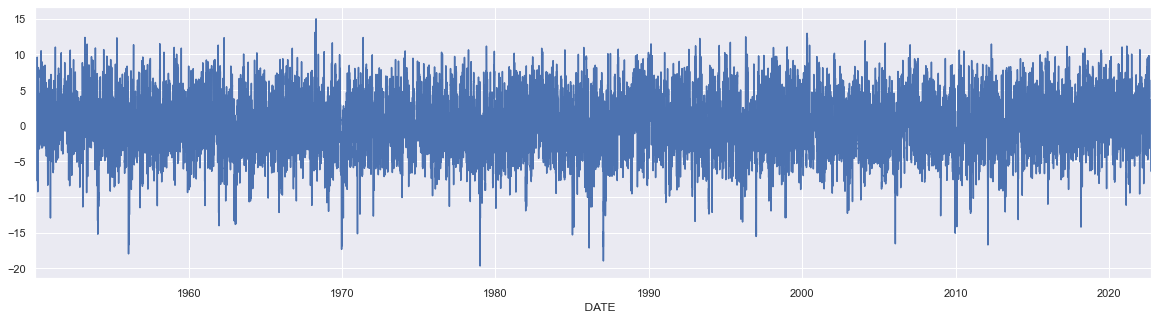

In [334]:
df_combined.remainder.plot(figsize = (20, 5));

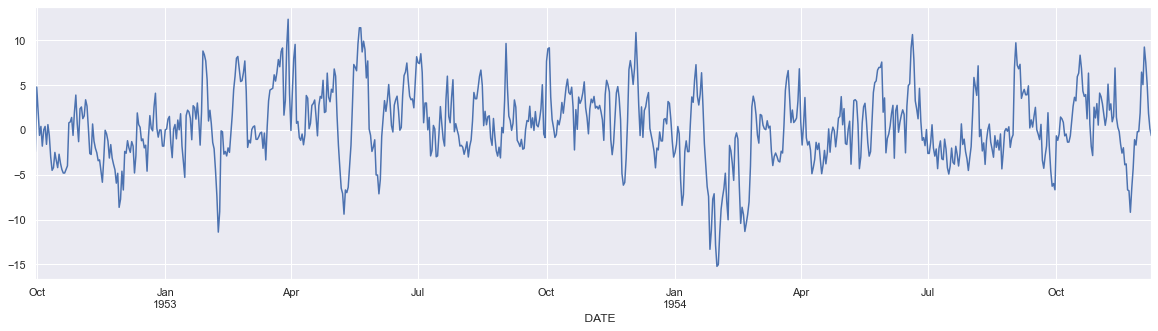

In [336]:
df_combined[1000:1800].remainder.plot(figsize = (20, 5));

In [338]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [339]:
print_adf(df_combined.remainder)
## looking at the p value below, we can with 99% confidence reliably reject the null hypothesis
## which states that the data is not stationary and can assume that the data has stationarity property

   
            adf: -23.35
            p: 0.0 
            used lag: 31 
            number of observations: 26536
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 119454.02724038158
            


## Next Notebook: ARIMA Model
